In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

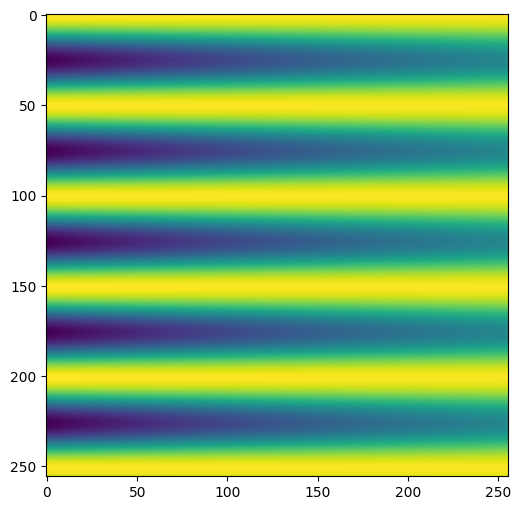

In [2]:
import numpy as np

from utils import save, load
from library import *
from continuous.process_library_terms import *
import matplotlib.pyplot as plt

#import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    #P = np.array(mat['P'])
    #U = np.array(mat['U'])
    #V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
#P = np.transpose(P, (1, 2, 0))
#U = np.transpose(U, (1, 2, 0))
#V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
#Nx = 256; Ny = Nx; Nt = 1000; # half resolution
Nx = 256; Ny = Nx; Nt = Nx # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
xg, yg = np.meshgrid(x, y)
U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

In [3]:
#%%prun # profiling

uobs = Observable(string='u', rank=1)
pobs = Observable(string='p', rank=0)
u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)
observables = [uobs, pobs]
data_dict = {'p': P, 'u': u}

# fix random seed
np.random.seed(1)

world_size = np.array(U.shape)
pad = 0

# fix random seed
np.random.seed(1)

dxs = [dx, dy, dt]
dom_width = 64
dom_time = 50

# initial setup of dataset
corr_L = 5
corr_T = 5

srd = SRDataset(world_size=world_size, data_dict=data_dict, observables=observables, dxs=dxs, 
                #irreps=SRDataset.all_rank2_irreps())
                irreps=(0, 1, 2))

# initialize libraries, domains, and weights
srd.make_libraries(max_complexity=4, max_observables=3)
#print(srd.libs[0].terms)

dom_width = 40
dom_time = 20 #previously 20 (without interpolation)
#srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=pad)
srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time], pad=pad)
srd.make_weights(m=12, qmax=1)
srd.set_LT_scale(L=np.sqrt(dx*dy), T=dt) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

In [4]:
from commons.sparse_reg_bf import *
from commons.identify_models import *
import copy

libs = srd.libs

# for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
scaler0 = Scaler(sub_inds=None, char_sizes=libs[0].col_weights, row_norms=None)
init0 = Initializer(method='combinatorial', start_k=2)
#init0 = Initializer(method='power', start_k=10)
#res0 = Residual(residual_type='fixed_column', anchor_col=0)
res0 = Residual(residual_type='dominant_balance')

iter0 = ModelIterator(max_k=10, backward_forward=True, brute_force=True)
thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
#thres0 = Threshold(threshold_type='information', ic=AIC)
#thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=3)

opts = {'scaler': scaler0, 'initializer': init0, 'residual': res0,
        'model_iterator': iter0, 'threshold': thres0}
opts['verbose'] = True
#opts1 = copy.deepcopy(opts) # need to be careful to deep copy for the stateful ModelIterator
opts['inhomog'] = False
opts['inhomog_col'] = None

opts1 = copy.deepcopy(opts)
#opts['verbose'] = False
# sub_inds1 = list(range(len(libs[1].terms)))
# opts1['scaler'] = Scaler(sub_inds=sub_inds1, char_sizes=libs[1].col_weights)
# opts1['residual'] = Residual(residual_type='fixed_column', anchor_col=13)
# opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
    
# opts['verbose']=False
# opts1['verbose']=False

# # note that interleave_identify doesn't work with inhomog or fixed-column residual
# opts1['inhomog'] = False
# opts1['inhomog_col'] = None
# opts1['residual'] = copy.deepcopy(opts['residual'])
# opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

opts2 = copy.deepcopy(opts)

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[i].Q for i in srd.irreps], 
#[opts, opts1, opts2], [libs[i].terms for i in srd.irreps], threshold=1e-4, experimental=True)
[copy.deepcopy(opts) for i in srd.irreps], [libs[i].terms for i in srd.irreps], threshold=1e-4, experimental=True, 
                                                                max_equations=10)

Checking single-term residuals...
nrm[0]: 1216.5414091323732
final lambda1: 1216.5414091323732
Result: p = 0 . residual: 1216.5414091323732
Checking single-term residuals...
nrm[0]: 367.86446150530776
final lambda1: 367.86446150530776
Result: u_α = 0 . residual: 367.86446150530776
Checking single-term residuals...
nrm[0]: 1216.5414091323732
nrm[1]: 1217.2540235685096
nrm[2]: 1696.1378000531968
nrm[3]: 1965.3523992611927
nrm[4]: 2889.514403153596
Initializing solution with starting k: 2
initial xi: [0.707 0.707 0.    0.    0.   ]
initial lambda: 7.071531937205906e-14
max_k set to 5
Iterating to find model...
Terms: [np.int64(0), np.int64(1)]
qc_col[0]: 1216.5414091323732
qc_col[1]: 1217.2540235685096
Residual normalization: 860.4765165867288
Direction: backward; k: 2
Scores of terms to add: [(2, 3.4880161129308295e-14), (3, 7.815838830134084e-15), (4, 1.8674698217276785e-13)]
Adding term: 3
xi: [ 7.073e-01  7.069e-01  0.000e+00 -3.430e-17  0.000e+00]
lambda: 1.617724890358989e-13
terms:

AssertionError: Didn't find any indexings for u_α · u_γ · ∂γ u_δ with rank 4 :(